# Logistic Regression Modeling

## Import

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.base import TransformerMixin, BaseEstimator

## Preprocessing Methods
import nltk
from nltk.corpus import stopwords

import nltk
try:
    nltk.data.find('stopwords')
    nltk.data.find('punkt')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
# nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import sys
import os
import pprint
sys.path.insert(
    0,
    os.path.abspath("..")
)

In [15]:
from Experiments.preprocessing import Preprocesser
from Experiments.all_minilm import HuggingFaceClassifier
from Experiments.svd import TextClassifier
from Experiments.classifier import Classifier

# Choose Preprocessing Methods

What's Important?
- Stopword Removal (max_df and min_df for tfidf-vectorizer)
- What dates of data should I include? Try seeing topic trends.
- Feature Importance
- Evaluation Metrics

Our Pipeline should look like this:
**Preprocessing:**
- Combine relevant columns into one column
- Apply stopword removal

**Vectorizer:**
- Configure vectorizer parameters and pickle if necessary (On Colab GPU or locally)

**Evaluate Feature Importance:**

**Cross-Validate and Get Test Results**





# EDA on Topic Trends (If Time)

Use BERTopic

# Experiments on CDESCR

## Experiment 1: 
TFIDF Vectorizer, with standard stopwords removal and lemmatization, into SGDClassifier

In [16]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,2),
        min_df=20,
        max_df=0.7,
        binary=True
    )
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:88: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [17]:
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="base_lr",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"],
    rerun=True
)

In [18]:
c.fit()

In [19]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.99      0.99      1150\n'
 '           1       0.99      1.00      1.00      2587\n'
 '\n'
 '    accuracy                           1.00      3737\n'
 '   macro avg       1.00      0.99      0.99      3737\n'
 'weighted avg       1.00      1.00      1.00      3737\n')


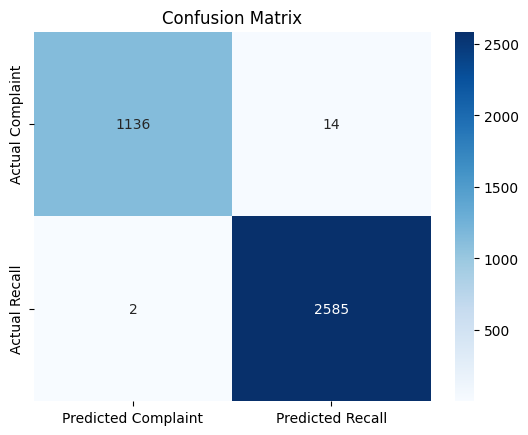

In [20]:
_ = c.plot_heatmap()

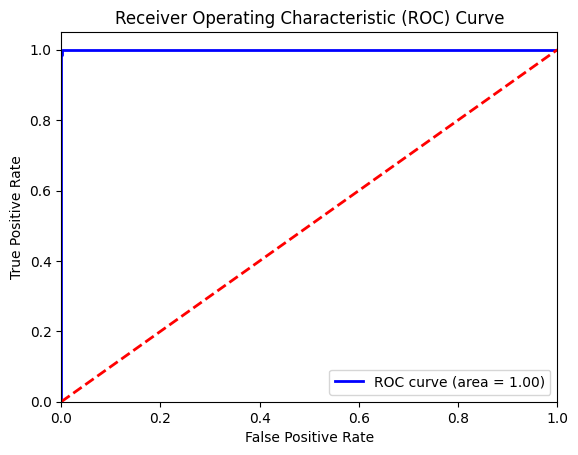

In [21]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '10 LARGEST Coefficients Leading to Recall'}, xlabel='Feature Names', ylabel='LR Coefficients'>

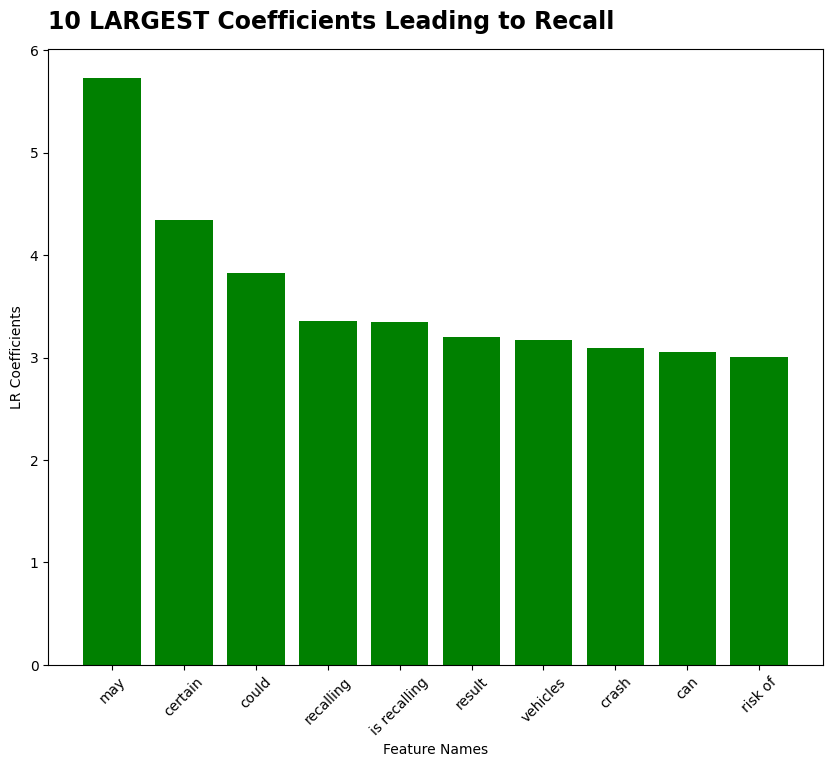

In [22]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=10
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '10 SMALLEST Coefficients Leading to Complaint'}, xlabel='Feature Names', ylabel='LR Coefficients'>

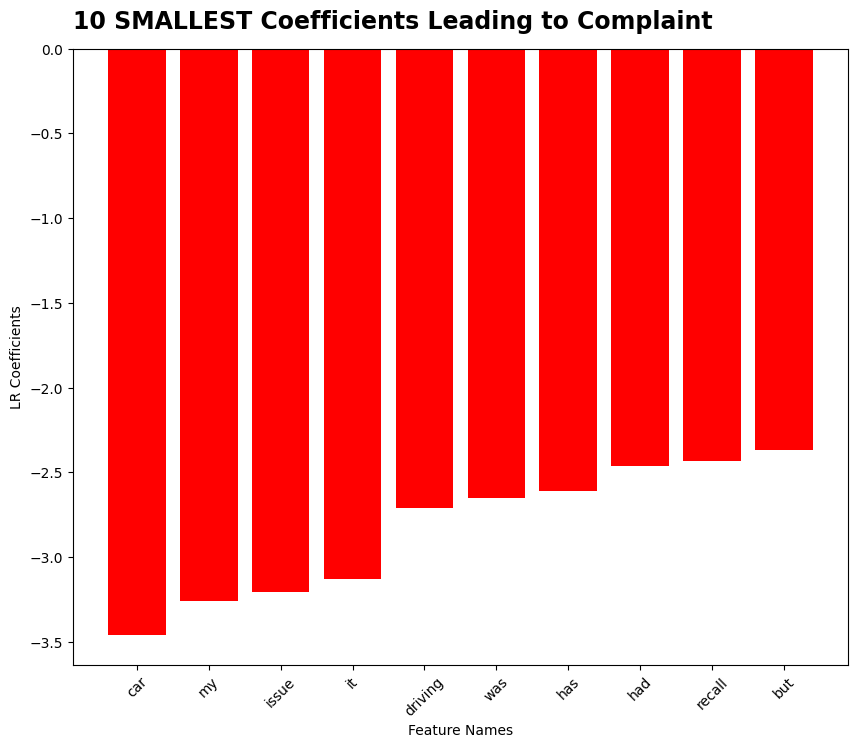

In [23]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=10
)

In [24]:
top_50_feature_importance_1 = c.get_feature_importance(
    p.vectorizer,
    type="largest",
    top=50
)

In [25]:
bottom_50_feature_importance_1 = c.get_feature_importance(
    p.vectorizer,
    type="smallest",
    top=50
)

## Experiment 2: 
TFIDF Vectorizer, with specific stopwords removal and lemmatization, into SGDClassifier

In [26]:
stopwords_top = top_50_feature_importance_1["feature_names"].tolist()
stopwords_bottom = bottom_50_feature_importance_1["feature_names"].tolist()

In [27]:
stopwords_top = [stopword for stopword in stopwords_top if stopword.find(" ") == -1]
stopwords_bottom = [stopword for stopword in stopwords_bottom if stopword.find(" ") == -1]

In [28]:
stopwords_top = list(set(stopwords_top) - {"motor"})
stopwords_bottom = list(set(stopwords_bottom) - {"coolant", "motor", "transmission"})

In [29]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords_2",
    extra_stopwords = (
        stopwords_top + stopwords_bottom
    ),
    custom_vectorizer_name="tfidf_binary_unigram_bigram_2",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.7,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:88: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [37]:
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="lr_stopwords_2",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"],
    rerun=True
)

In [38]:
c.fit()

In [39]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.96      0.98      1150\n'
 '           1       0.98      1.00      0.99      2587\n'
 '\n'
 '    accuracy                           0.99      3737\n'
 '   macro avg       0.99      0.98      0.98      3737\n'
 'weighted avg       0.99      0.99      0.99      3737\n')


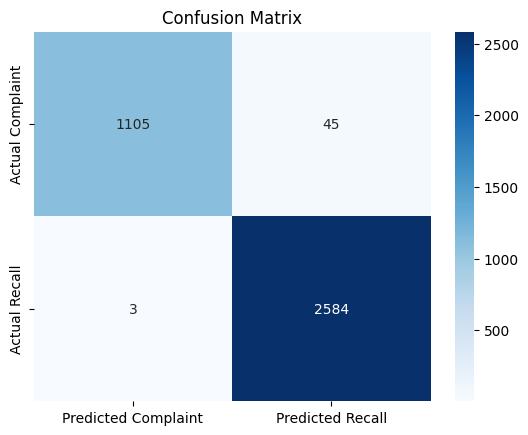

In [40]:
_ = c.plot_heatmap()

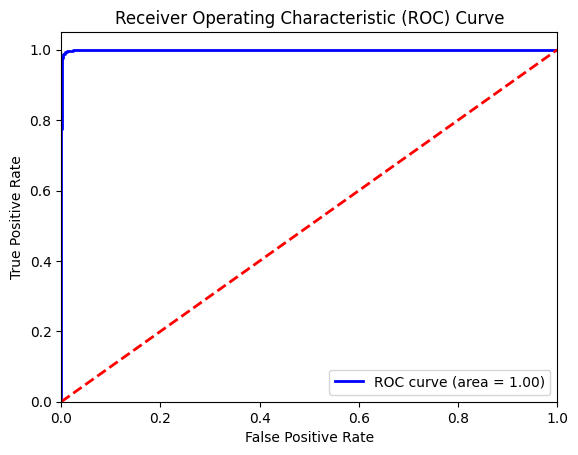

In [41]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 LARGEST Coefficients Leading to Recall'}, xlabel='Feature Names', ylabel='Logistic Regression Coefficients'>

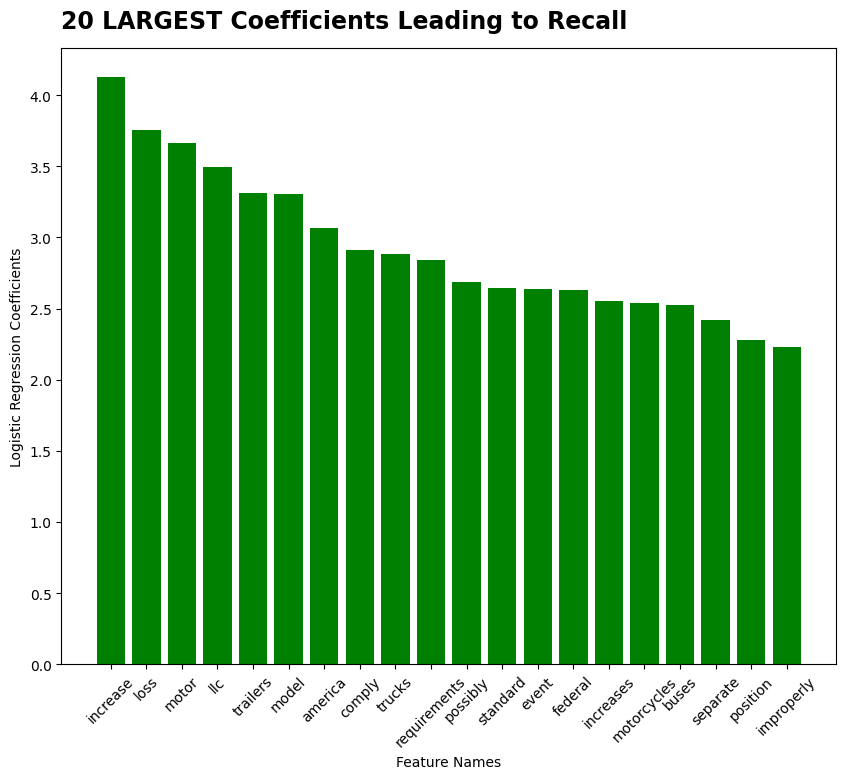

In [42]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 SMALLEST Coefficients Leading to Complaint'}, xlabel='Feature Names', ylabel='Logistic Regression Coefficients'>

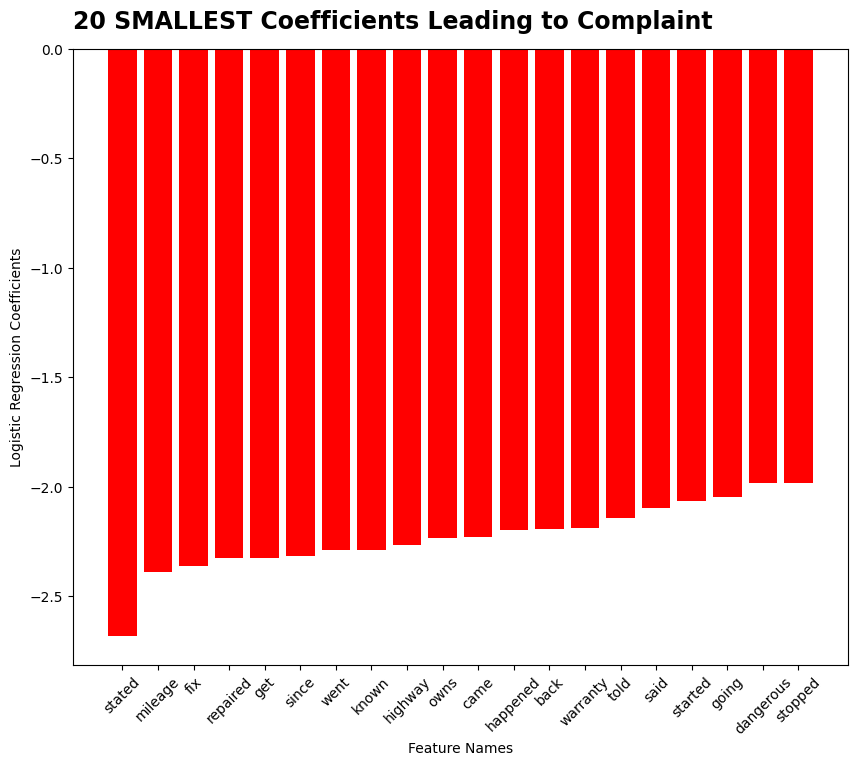

In [43]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

In [103]:
top_50_stopwords_2 = c.get_top_stopwords(
    p.vectorizer,
    type="largest"
)
bottom_50_stopwords_2 = c.get_top_stopwords(
    p.vectorizer,
    type="smallest"
)

## Experiment 3: 
Try lower max_df

In [104]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_max_df_0.3",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.3,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:84: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [105]:
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="lr_stopwords_max_df_0.3",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"],
    rerun=True
)

In [106]:
c.fit()

In [107]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.98      0.99      1150\n'
 '           1       0.99      1.00      0.99      2587\n'
 '\n'
 '    accuracy                           0.99      3737\n'
 '   macro avg       0.99      0.99      0.99      3737\n'
 'weighted avg       0.99      0.99      0.99      3737\n')


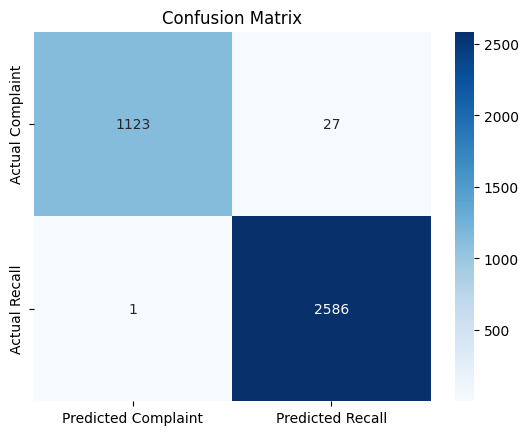

In [108]:
_ = c.plot_heatmap()

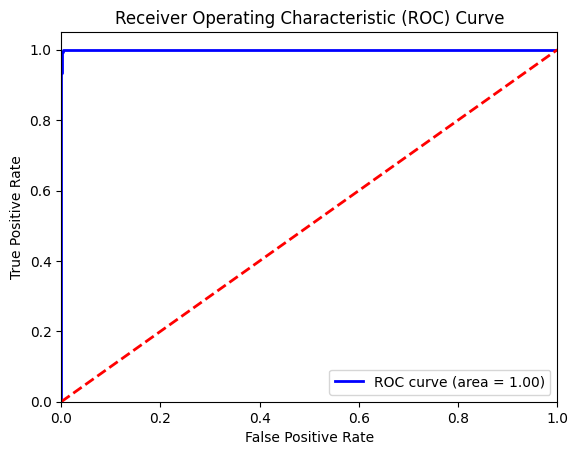

In [109]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 largest Coefficients'}, xlabel='Feature Names', ylabel='LR Coefficients'>

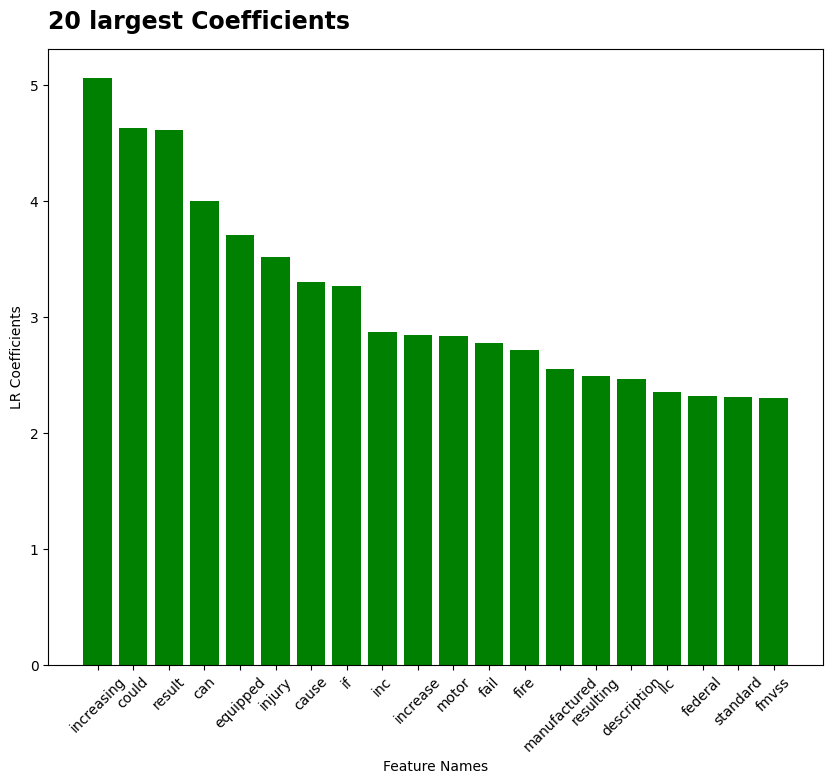

In [110]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 smallest Coefficients'}, xlabel='Feature Names', ylabel='LR Coefficients'>

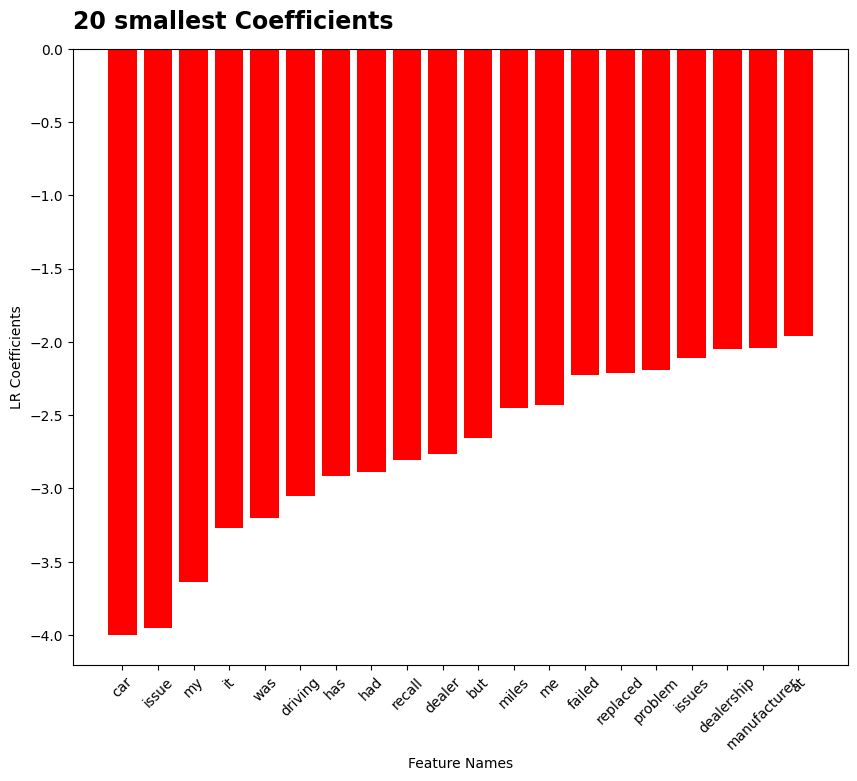

In [111]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

## Experiment 4: 
Try even lower max_df

In [44]:
p = Preprocesser(
    "CDESCR",
    custom_clean_name="nltk_stopwords",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_max_df_0.01",
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,1),
        min_df=20,
        max_df=0.01,
        binary=True
    ),
    is_stem=False
)
p.preprocess()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:88: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [45]:
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="lr_stopwords_max_df_0.01",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"]
)

In [46]:
c.fit()

In [47]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.99      0.87      0.93      1150\n'
 '           1       0.95      1.00      0.97      2587\n'
 '\n'
 '    accuracy                           0.96      3737\n'
 '   macro avg       0.97      0.93      0.95      3737\n'
 'weighted avg       0.96      0.96      0.96      3737\n')


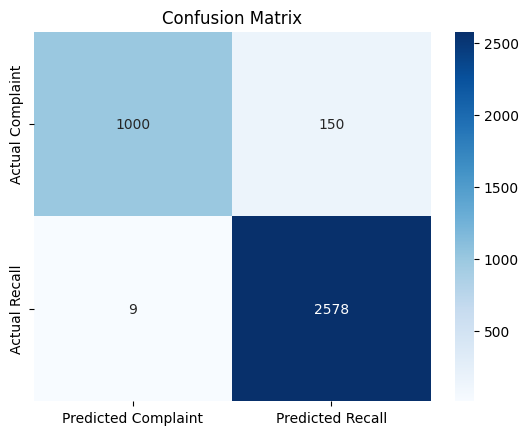

In [48]:
_ = c.plot_heatmap()

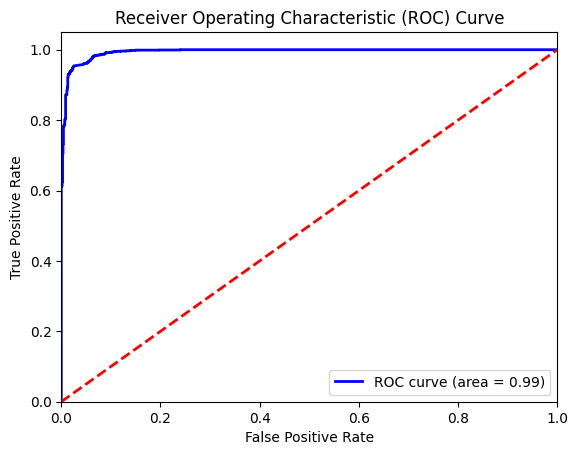

In [49]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 LARGEST Coefficients Leading to Recall'}, xlabel='Feature Names', ylabel='Logistic Regression Coefficients'>

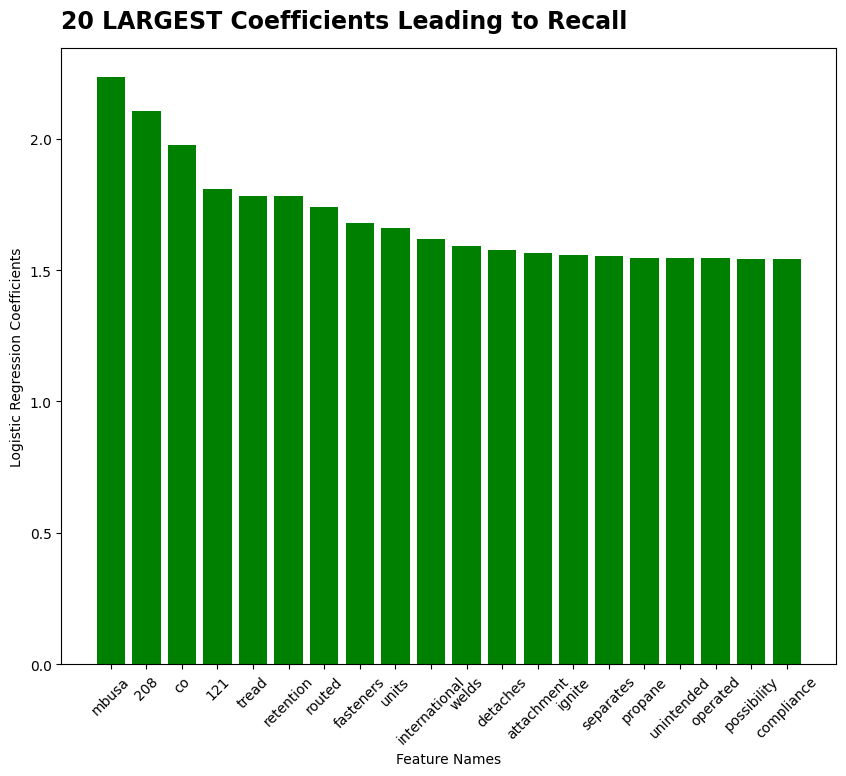

In [50]:
c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


<Axes: title={'center': '20 SMALLEST Coefficients Leading to Complaint'}, xlabel='Feature Names', ylabel='Logistic Regression Coefficients'>

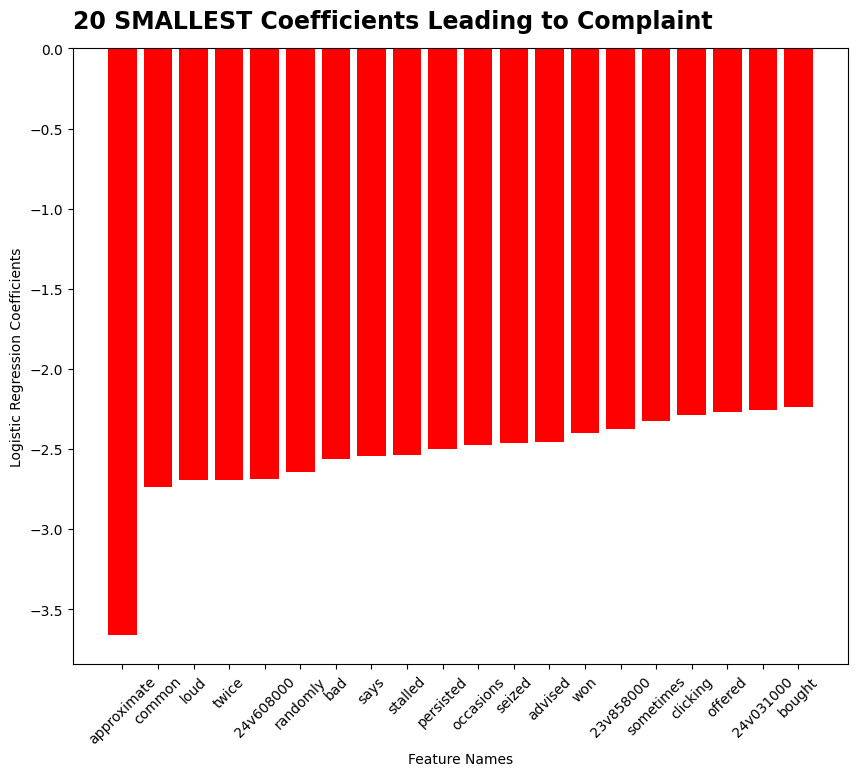

In [51]:
c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)

## What We Learned:
- Characters containing numbers can most likely be left out
- Recall contains a lot of junk information as expected. Might want to borrow columns other than CDESCR, which is a combination of DESC_DEFECT and CONSEQUENCE_EFFECT

# Experiments on CDESCR, COMPONENT

## Experiment 5:

In [59]:
recall_stopwords = ["crash", "risk", "increasing", "increase", "increases", "increased", "may", "could",
 "injury", "equipment", "loss", "resulting", "condition", "occur", "result", "event", "labels", "possibly"]

complaint_stopwords = ["engine", "unknown", "car", "driving", "issue", "dealer", "failed", "problem",
 "dealership", "issues", "times", "service", "back", "safety", "recall", "due", "like",
 ]

In [60]:
p = Preprocesser(
    "CDESCR_AND_COMPONENT",
    custom_clean_name="nltk_stopwords_cdescr_and_components",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_cdescr_and_component",
    extra_stopwords=recall_stopwords + complaint_stopwords,
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,2),
        min_df=20,
        max_df=0.7,
        binary=True
    ),
    is_stem=False,
    rerun=True
)
p.preprocess()
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="lr_cdescr_and_components",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_validation_vect,
    y_test = p.df_validation["IS_RECALL"],
    rerun=True
)
c.fit()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:88: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [61]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.92      0.96      1150\n'
 '           1       0.97      1.00      0.98      2587\n'
 '\n'
 '    accuracy                           0.98      3737\n'
 '   macro avg       0.98      0.96      0.97      3737\n'
 'weighted avg       0.98      0.98      0.98      3737\n')


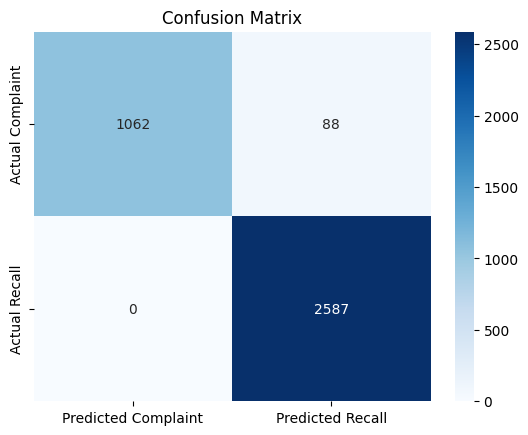

In [62]:
_ = c.plot_heatmap()

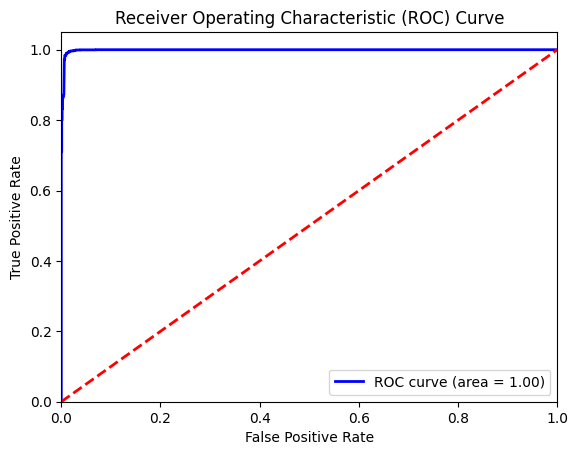

In [63]:
_ = c.plot_roc_auc_score()

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\harri\AppData\Local\Temp\ipykernel_37132\3595027896.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


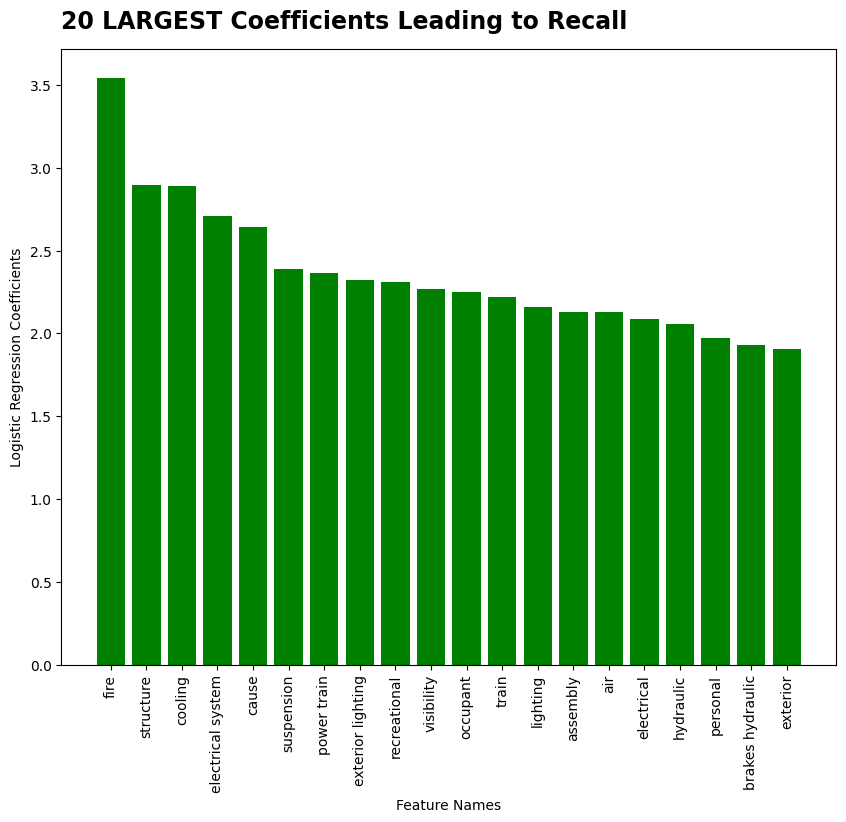

In [66]:
ax = c.plot_feature_importance(
    p.vectorizer,
    type="largest",
    top=20
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\classifier.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\harri\AppData\Local\Temp\ipykernel_37132\2130617713.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


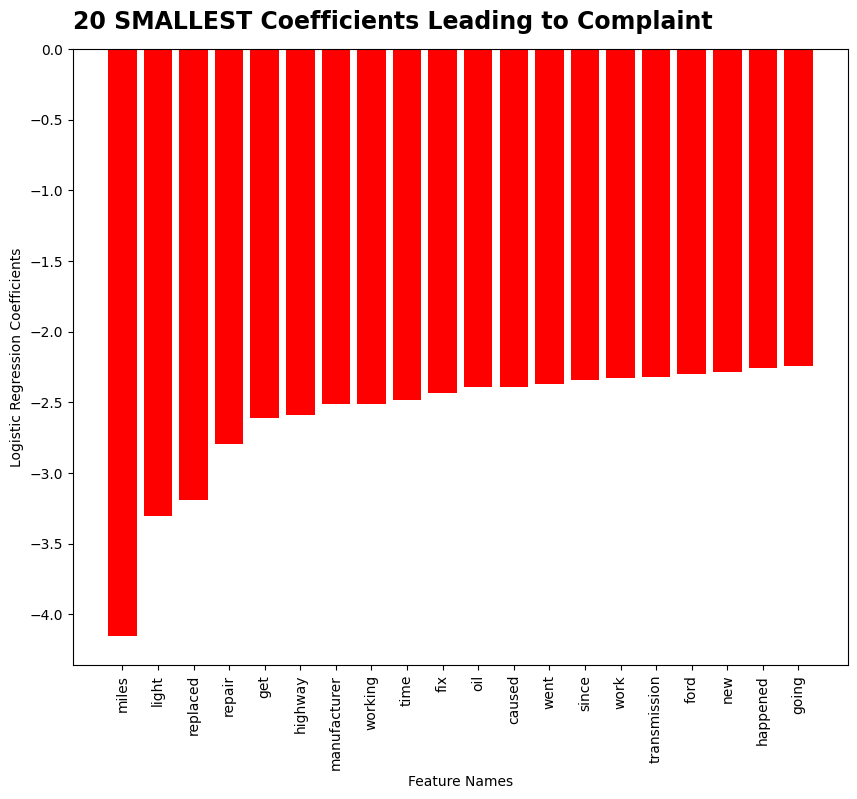

In [67]:
ax = c.plot_feature_importance(
    p.vectorizer,
    type="smallest",
    top=20
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [104]:
c.predict(
    "Electrical system failure",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.03452182, 0.96547818]])

## Test Results

In [6]:
recall_stopwords = ["crash", "risk", "increasing", "increase", "increases", "increased", "may", "could",
 "injury", "equipment", "loss", "resulting", "condition", "occur", "result", "event", "labels", "possibly"]

complaint_stopwords = ["engine", "unknown", "car", "driving", "issue", "dealer", "failed", "problem",
 "dealership", "issues", "times", "service", "back", "safety", "recall", "due", "like",
 ]

In [ ]:
p = Preprocesser(
    "CDESCR_AND_COMPONENT",
    custom_clean_name="nltk_stopwords_cdescr_and_components",
    custom_vectorizer_name="tfidf_binary_unigram_bigram_cdescr_and_component",
    extra_stopwords=recall_stopwords + complaint_stopwords,
    vectorizer=TfidfVectorizer,
    vectorizer_params=dict(
        ngram_range=(1,2),
        min_df=20,
        max_df=0.7,
        binary=True
    ),
    is_stem=True,
    rerun=True
)
p.preprocess()
c = Classifier(
    classifier=SGDClassifier,
    classifier_params=dict(
        random_state=42,
        loss="log_loss"
    ),
    custom_classifier_name="lr_cdescr_and_components",
    X_train = p.x_train_vect,
    y_train = p.df_train["IS_RECALL"],
    X_test = p.x_test_vect,
    y_test = p.df_test["IS_RECALL"],
    rerun=True
)
c.fit()

Reading CSV


c:\Users\harri\OneDrive\Documents\Programming\UMich_Data_Science\SIADs_Audio_Text_SRS\Experiments\preprocessing.py:88: DtypeWarning: Columns (1,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,42,44,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_path)


Cleaning Text
Vectorizing


In [8]:
pprint.pprint(
    c.evaluate()
)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.94      0.97      1168\n'
 '           1       0.97      1.00      0.99      2567\n'
 '\n'
 '    accuracy                           0.98      3735\n'
 '   macro avg       0.99      0.97      0.98      3735\n'
 'weighted avg       0.98      0.98      0.98      3735\n')


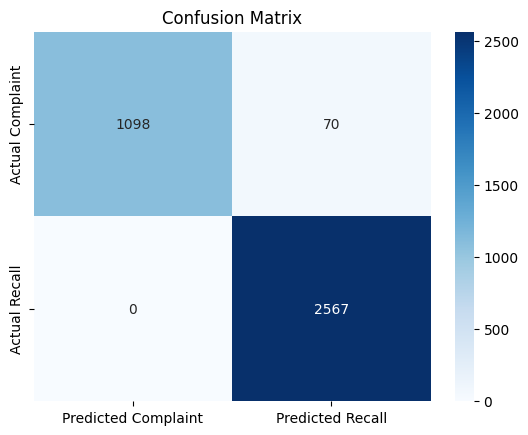

In [9]:
_ = c.plot_heatmap()

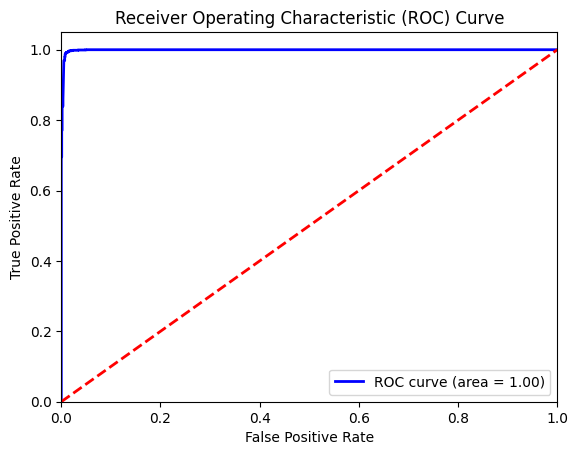

In [11]:
_ = c.plot_roc_auc_score()

In [105]:
c.predict(
    "Software going crazy boy",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.54926224, 0.45073776]])

In [ ]:
c.predict(
    "speaker",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.1193035, 0.8806965]])

In [ ]:
c.predict(
    "engine",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.92692143, 0.07307857]])

In [ ]:
c.predict(
    "engine failure",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.79796651, 0.20203349]])

In [ ]:
c.predict(
    "engine stall",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.09982127, 0.90017873]])

In [ ]:
c.predict(
    "engine light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.84267902, 0.15732098]])

In [ ]:
c.predict(
    "air bag",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.14630867, 0.85369133]])

In [ ]:
c.predict(
    "air bag sensor",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.18760131, 0.81239869]])

In [ ]:
c.predict(
    "transmission",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.26633324, 0.73366676]])

In [ ]:
c.predict(
    "harsh brake",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.15055563, 0.84944437]])

In [ ]:
c.predict(
    "engine stalling",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.09982127, 0.90017873]])

In [ ]:
c.predict(
    "engine clicking sound",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.71180739, 0.28819261]])

In [ ]:
c.predict(
    "brake",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.17627448, 0.82372552]])

In [ ]:
c.predict(
    "door open",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.18169663, 0.81830337]])

In [ ]:
c.predict(
    "loose bolt",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.06607795, 0.93392205]])

In [ ]:
c.predict(
    "light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.5481595, 0.4518405]])

In [ ]:
c.predict(
    "light sensor",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.55918151, 0.44081849]])

In [ ]:
c.predict(
    "sensor is broken",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.2738067, 0.7261933]])

In [ ]:
c.predict(
    "misfire",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.15848719, 0.84151281]])

In [ ]:
c.predict(
    "speaker rattling",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.1377794, 0.8622206]])

In [ ]:
c.predict(
    "steering wheel uneven",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.268095, 0.731905]])

In [ ]:
c.predict(
    "steering wheel",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.34872392, 0.65127608]])

In [ ]:
c.predict(
    "wheel jitter",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.08747588, 0.91252412]])

In [ ]:
c.predict(
    "check engine light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

array([[0.86939945, 0.13060055]])

## Try Plotting 

Complaint is yellow/orange

Recall is salmon red

In [19]:
import matplotlib.pyplot as plt

In [36]:
lr_prediction = c.predict(
    "check engine light",
    p.vectorizer,
    p.process_text,
    text_process_params=dict(
        stopwords=set(stopwords.words("english")) | set(p.extra_stopwords),
        is_stem=True
    ),
    is_proba=True
)

In [37]:
lr_prediction = (lr_prediction.flatten() * 100).round(2)

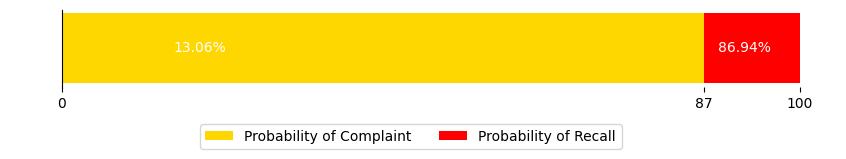

In [61]:
fig, ax = plt.subplots(figsize=(10, 1), dpi=100)
y = 0
ax.barh(y, lr_prediction[0], label="Probability of Complaint", color="#FFD700")
ax.barh(y, lr_prediction[1], left=lr_prediction[0], label="Probability of Recall", color="#FF0000")
ax.tick_params(axis="y", colors="white")
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([0, lr_prediction[0], 100])
for index, value in enumerate(lr_prediction):
    ax.text(x=value + 2, y=0, s=f"{value}%", ha="left", va='center', color='white')
ax.legend(loc="lower center", bbox_to_anchor=(0.45, -0.9), ncols=2)

## Experiment 6:

Try SVD on TfIDF-Vector, then predict complaint and recall